# CS5200 Computer Architecture - Project 1

In this project we used the gem5 simulator to run an experiment on two CPUs changing features of the memory hierarchy and evaluated the sensitivity of changing these features. The primary response that was evaluated is the total simulation time.
- **CPU:** TimeSimpleCPU, O3CPU
- **CPU Clock:** 1GHz, 1.5GHz, 2GHz, 2.5GHz, 3GHz
- **L1 Data Cache Size:** 64kB, 128kB
- **L1 Data Cache Association:** Direct-Mapped (1), 2-way (2)
- **L1 Instruction Cache Size:** 32kB, 64kB
- **L1 Instruction Cache Association:** Direct-Mapped (1), 2-way (2)
- **RAM:** DDR3_1600_8x8, DDR3_2133_8x8, LPDDR2_S4_1066_1x32

In [2]:
import read_data
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (10, 5)

## 1. Import Data
After running the experiment in gem5, the `stats.txt` output files were copied from the Docker container and need to be read and saved into a pandas DataFrame. I decided to drop the first two rows that contain the results from Part 1 and Part 2 because they are outliers compared to the remaining 92 data points and, in my opinion, are an apples and oranges comparison because they do not contain any cache memory.

In [4]:
df = read_data.get_data()
df.head()

,time,part,cpu,cpu_clock,l1d_size,l1d_assoc,l1i_size,l1i_assoc,l2_size,l2_assoc,dram
2,0.007460,p3,TimingSimpleCPU,1.0,64kB,1,32kB,1,4MB,8,DDR3_1600_8x8
3,0.002700,p3,O3CPU,1.0,64kB,1,32kB,1,4MB,8,DDR3_1600_8x8
4,0.013199,p4,TimingSimpleCPU,1.0,64kB,1,32kB,1,4MB,8,DDR3_1600_8x8
5,0.009391,p4,TimingSimpleCPU,1.5,64kB,1,32kB,1,4MB,8,DDR3_1600_8x8
6,0.007460,p4,TimingSimpleCPU,2.0,64kB,1,32kB,1,4MB,8,DDR3_1600_8x8


## 2. Examine Features Impact on Response
### Question 1: Which CPU Model is More Sensitive to Changing CPU Frequency?
In order to quickly inspect the affect of the CPU clock on simulation time, we can visually inspect the change in time as the CPU frequency increases. We will do this by calculating an average for each CPU, CPU clock combination and plotting a line plot to see the trend of simulation time over the CPU frequency. 

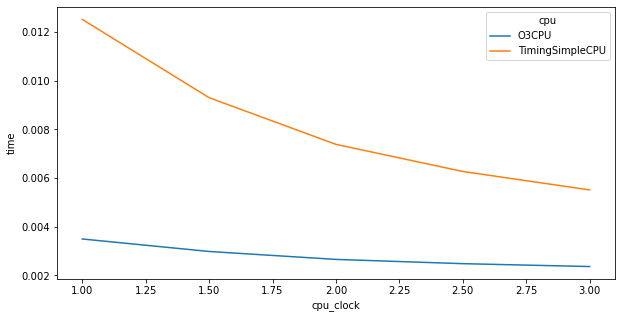

In [3]:
q1 = df.groupby(['cpu','cpu_clock']).mean().time.reset_index()
sns.lineplot(data=q1, x='cpu_clock', y='time', hue='cpu')
plt.show()

It is apparent that the TimingSimpleCPU (orange) is more sensitive to the CPU frequency compared to the O3CPU (blue) because the simulation time decreases more as the frequency increases where the O3CPU simulation time remains relatively unchanged as the frequency increases.

### Question 2: Which CPU Model is More Sensitive to Changing Memory Technology?

An easy way to observe the sensitivity of changing memory technology is to use a bar plot.

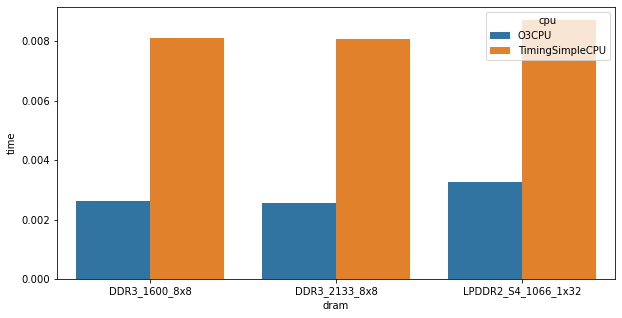

In [4]:
q2 = df.groupby(['cpu','dram']).mean().time.reset_index()
sns.barplot(data=q2, x='dram', y='time', hue='cpu')
plt.show()

After plotting the simulation time for each memory technology, it remains unclear which CPU is more sensitive to changing memory technology because for both CPU models the DDR3_1600 takes about the same amount of time, on average, as the DDR3_2133 and the LPDDR2_S4_1066 is higher. The O3CPU might be slightly more sensitive to change since the times are lower and the increase appears to be the same (quantity) as the TimingSimpleCPU, which indicates a greater percentage of change from the DDR3 memory types to the LPDDR2 memory.

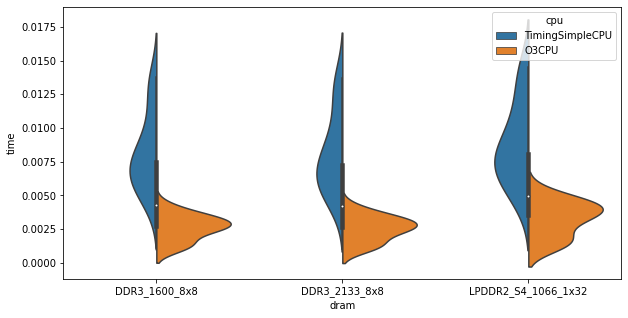

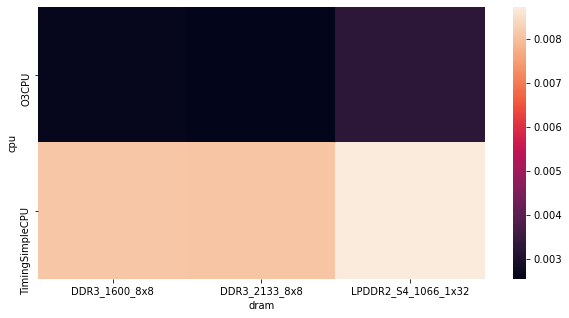

In [85]:
sns.violinplot(data=df[['dram', 'time', 'cpu']], x='dram', y='time', hue='cpu', split=True)
plt.show()
sns.heatmap(q2.pivot(index='cpu', columns='dram', values='time'))
plt.show()

After inspecting a violin plot to gain a better understanding of the distribution of data points (instead of simply the average) and a heatmap to visually inspect the color changes between memory types, it still is unclear if one CPU is more sensitive to changing memory. Therefore, we can simply inspect the speedup of DDR3_1600_8x8 compared to the LPDDR2_S4_1066 for both CPU models and conclude that the O3CPU is more sensitive to the change from either DDR3 to LPDDR2 memory type.

In [88]:
O3 = q2.time[2] / q2.time[0]
TimingSimple = q2.time[5] / q2.time[3]
print('O3:', O3)
print('TimingSimple:', TimingSimple)

O3: 1.244246036457468
TimingSimple: 1.0752338081437176


### Question 3: Is the Sieve Application more Sensitive to the CPU frequency or the Memory Technology?

One way of answering this question is to visually inspect the change in simulation time for each memory type as the CPU frequency increases. The plot below suggests that the differences between the three memory technologies remains fairly constant for all frequencies (nearly the same for DDR3_1600 and DDR3_2133 and less than 0.001 seconds comparing either DDR3 to LPDDR2), where the simulation time decreases more significantly (around 0.004 seconds) as the frequency increases.

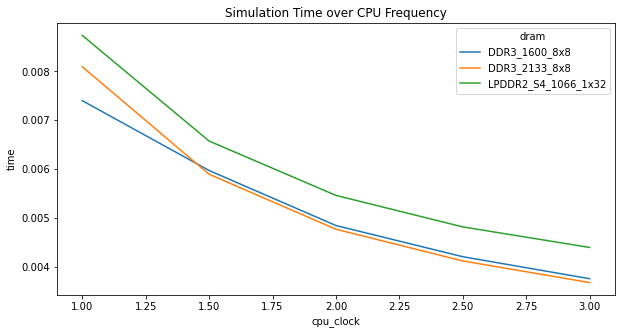

In [38]:
q3 = df.groupby(['cpu_clock','dram']).mean().time.reset_index()
sns.lineplot(data=q3, x='cpu_clock', y='time', hue='dram')
plt.title('Simulation Time over CPU Frequency')
plt.show()

To confirm this visual inspection we can impliment feature selection using linear regression. Below are the results of an Ordinary Least Squares linear regression model where the features are `cpu_clock` and `dram` and the response/target is `time`. The R-squared value is extremely low, so this model's coefficients should not be used to predict simulation time, but this model does shed some light about the significance of its features. The results suggest that `cpu_clock` is a statistically significant feature (p < 0.05) and `dram` is not (p = 0.363), indicating that the sieve application might be more sensitive to CPU frequency than memory technology. 

In [33]:
x = df[['cpu_clock','dram']]
y = df['time']
x = sm.add_constant(x)
x.dram = x.dram.map({'DDR3_1600_8x8':1,
                     'DDR3_2133_8x8': 2,
                     'LPDDR2_S4_1066_1x32': 3
                    })
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     9.560
Date:                Tue, 04 Oct 2022   Prob (F-statistic):           0.000173
Time:                        08:14:46   Log-Likelihood:                 399.17
No. Observations:                  92   AIC:                            -792.3
Df Residuals:                      89   BIC:                            -784.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.001      7.032      0.0

### Question 4: Comparing L1 Cache Performace
#### Why does the Smaller Direct-Mapped L1 Cache Perform Better/Worse/Similar to the Larger Direct-Mapped L1 Cache?
The smaller L1 cache contains a data cache of 64kB and an instruction cache of 32kB, where the larger direct-mapped L1 cache has double these values (data: 128kB, instruction: 64kB). The larger L1 cache outperforms the small L1 cache most likely due to the fact that with a larger cache there is a lower probability of running into a cache miss. The larger L1 cache has a speedup of 1.33 or 33% speedup.

In [45]:
q4 = df[['l1d_size', 'l1d_assoc', 'time']]

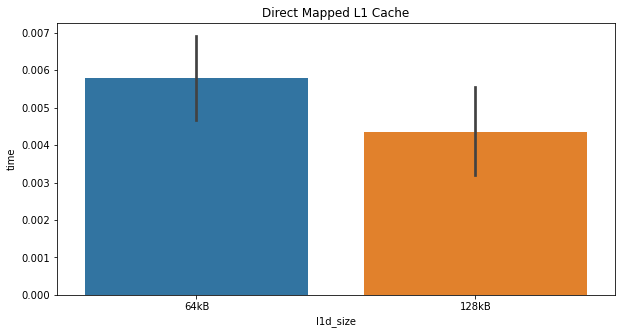

In [46]:
sns.barplot(data=q4.loc[q4.l1d_assoc==1], x='l1d_size', y='time')
plt.title('Direct Mapped L1 Cache')
plt.show()

In [58]:
q4a = q4.loc[q4.l1d_assoc==1].groupby('l1d_size').mean().time
q4a[1] / q4a[0]

1.3307237189949663

#### Why does the Smaller Direct-Mapped L1 Cache Perform Better/Worse/Similar to the Same-Sized 2-way L1 Cache?
The direct-mapped L1 cache slightly outperforms the 2-way set-associative L1 cache possibly because there might not be many overlaps in memory location indices (typically the downfall of direct-mapped cache). Additionally, the nature of a set-associative cache structure is a little slower because there is a little extra overhead. The direct-mapped L1 cache has a speedup of 1.125 or 12.5% speedup.

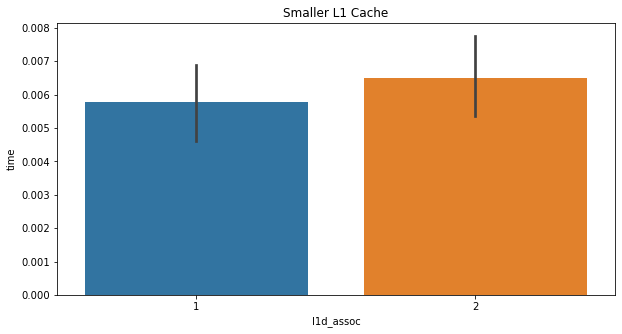

In [43]:
sns.barplot(data=q4.loc[q4.l1d_size=='64kB'], x='l1d_assoc', y='time')
plt.title('Smaller L1 Cache')
plt.show()

In [67]:
q4b = q4.loc[q4.l1d_size=='64kB'].groupby('l1d_assoc').mean().time
q4b[2] / q4b[1]

1.124698455885396

#### Why does the Larger Direct-Mapped L1 Cache Perform Better/Worse/Similar to the Smaller 2-way L1 Cache?
The direct-mapped larger L1 cache outperforms the 2-way set-associative smaller L1 cache due to the two descriptions above. The first plot shows the larger cache performs better and the second plot shows the direct-mapped cache performs better, so unsurprisingly, combining the two provided the same result. The direct-mapped larger L1 cache has a speedup of 1.50 or 50% speedup.

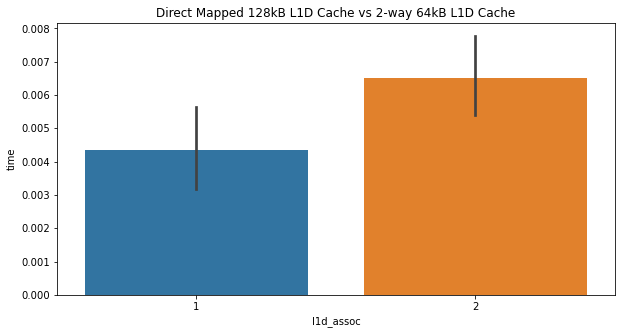

In [74]:
sns.barplot(data=q4.loc[~((q4.l1d_size=='64kB') & (q4.l1d_assoc==1))], x='l1d_assoc', y='time')
plt.title('Direct Mapped 128kB L1D Cache vs 2-way 64kB L1D Cache')
plt.show()

In [73]:
q4c = q4.loc[~((q4.l1d_size=='64kB') & (q4.l1d_assoc==1))].groupby(['l1d_size','l1d_assoc']).mean().time
q4c[1] / q4c[0]

1.4966629119637105

### Question 5: Assuming Same Cost to Increase the Associativity of L1 Cache from 1 to 2, Double Size of L1 Cache, or Use DDR3_2133_8x8 Memory, Which of These Changes, if any, Should You Choose? Why?
Looking at the table below immediately shows that the type of DRAM yields negligible difference in performance. Referencing the speedup calculated above, the largest performance increase comes from doubling the size of the L1 cache with a speedup of 33% compared to the 12% increase when changing from direct-mapped to 2-way set associative cache.

In [81]:
q5 = df.groupby(['l1d_size','l1d_assoc', 'dram']).mean().time.reset_index()
q5.loc[(q5.dram == 'DDR3_1600_8x8')|(q5.dram == 'DDR3_2133_8x8')]

,l1d_size,l1d_assoc,dram,time
0,128kB,1,DDR3_1600_8x8,0.004304
1,128kB,1,DDR3_2133_8x8,0.004284
3,64kB,1,DDR3_1600_8x8,0.005538
4,64kB,1,DDR3_2133_8x8,0.005538
6,64kB,2,DDR3_1600_8x8,0.006235
7,64kB,2,DDR3_2133_8x8,0.006110


### Question 6: If You Were to Use a Different Application, Do You Think Your Conclusions Would Change?

Assuming this different application allows identical changes and setup to the memory structure, I do not believe my conclusions would change. The comparisons run are application agnostic because we remove the influence of the application by when comparing features to each other. It is possible that another application would yield different simulation times, but the comparisons between features would yield the same conclusions.